In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir ~/.kaggle
!cp /content/drive/'My Drive'/data/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!mkdir kaggle
%cd kaggle

In [ ]:
!kaggle competitions download -c 'the-nature-conservancy-fisheries-monitoring'

In [ ]:
!p7zip -d test_stg2.7z && rm test_stg2.7z
!unzip train.zip && rm train.zip
!unzip test_stg1.zip && rm test_stg1.zip

In [ ]:
%cd kaggle

In [5]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16, Xception
import zipfile

print(tf.__version__)
print(tf.executing_eagerly())

2.3.0
True


In [6]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (300, 187) #(752, 468) # (1200, 750) try original size
BATCH_SIZE = 32
EPOCHS = 100

train_files = glob('train/**/*.jpg', recursive = True)
test_files_1 = glob('test_stg1/*.jpg')
test_files_2 = glob('test_stg2/*.jpg')

# Functions

In [7]:
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return tf.keras.applications.xception.preprocess_input(img)

def fit_generator(files, batch_size=BATCH_SIZE):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [8]:
def confidence_loss(y_true, y_pred):
    conf_loss = tf.keras.backend.binary_crossentropy(y_true[..., 0], y_pred[..., 0], from_logits=True)
    return conf_loss

In [9]:
def smooth_l1(y_true, y_pred):
    abs_loss = tf.keras.backend.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * tf.keras.backend.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = tf.keras.backend.cast(tf.keras.backend.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return tf.keras.backend.sum(total_loss, axis=-1)

In [10]:
def class_loss(y_true, y_pred):
    y_true = tf.keras.backend.reshape(y_true[1], (-1, 6))
    y_pred = tf.keras.backend.reshape(y_pred[1], (-1, 6))
    class_loss = tf.keras.backend.categorical_crossentropy(y_true, y_pred, from_logits=True)
    return class_loss

In [11]:
def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = tf.keras.backend.shape(y_true[0])[0]
    y_true = tf.keras.backend.reshape(y_true[0], (batch_size, -1, 5))
    y_pred = tf.keras.backend.reshape(y_pred[0], (batch_size, -1, 5))    
    conf_loss = confidence_loss(y_true, y_pred) # confidence loss
    loc_loss = smooth_l1(y_true, y_pred) # smooth l1 loss
    pos_conf_loss = tf.keras.backend.sum(conf_loss * y_true[..., 0], axis=-1) 
    pos_loc_loss = tf.keras.backend.sum(loc_loss * y_true[..., 0], axis=-1) # positive examples loss
    anchors = tf.keras.backend.shape(y_true)[1]
    num_pos = tf.keras.backend.sum(y_true[..., 0], axis=-1)
    num_pos_avg = tf.keras.backend.mean(num_pos)
    num_neg = tf.keras.backend.min([neg_pos_ratio * (num_pos_avg) + 1., tf.keras.backend.cast(anchors, 'float32')])
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]), k=tf.keras.backend.cast(num_neg, 'int32'))
    neg_conf_loss = tf.keras.backend.sum(neg_conf_loss, axis=-1) # hard negative mining
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32) # total conf loss
    return total_conf_loss + 0.5 * loc_loss

# Model

In [12]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                              monitor='val_loss',
                              patience=5,
                              min_delta=1e-7,
                              verbose=2,
                              factor=.5,
                              min_lr=1e-10,
                              mode='auto')

early_stopping = tf.keras.callbacks.EarlyStopping(
                              monitor='val_loss',
                              min_delta=1e-7,
                              patience=5,
                              verbose=2,
                              mode='auto',
                              restore_best_weights=False)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                              'model_VGG16_fish.h5',
                              monitor='val_loss',
                              verbose=1, 
                              save_best_only=True, 
                              save_weights_only=True,
                              mode='auto')

In [13]:
base_model = Xception(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# for layer in base_model.layers:
#     layer.trainable = False

input_layer = base_model.layers[-1].output

83689472/83683744 [==============================] - 4s 0us/step


In [14]:
# x = tf.keras.layers.Conv2D(2048, 3,3, activation='relu')(input_layer)
# x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(input_layer)
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)
x = tf.keras.layers.BatchNormalization()(x)
output_layer = tf.keras.layers.Dense(8, activation='softmax', kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output_layer)

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-8), 
              loss='binary_crossentropy',
              metrics='categorical_accuracy')

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 187, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 93, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 93, 32)  128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 93, 32)  0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [16]:
shuffle(train_files)
validation_data = next(fit_generator(train_files))
train_data = fit_generator(train_files)

hist = model.fit(train_data,
                 batch_size=BATCH_SIZE,
                 steps_per_epoch=len(train_files) // BATCH_SIZE,
                 epochs=EPOCHS,
                 validation_data=validation_data,
                 callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/100
118/118 [==============================] - ETA: 0s - loss: 0.4868 - categorical_accuracy: 0.1353WARNING:tensorflow:Model was constructed with shape (None, 300, 187, 3) for input Tensor("input_1:0", shape=(None, 300, 187, 3), dtype=float32), but it was called on an input with incompatible shape (32, 187, 300, 3).

Epoch 00001: val_loss improved from inf to 0.47244, saving model to model_VGG16_fish.h5
118/118 [==============================] - 181s 2s/step - loss: 0.4868 - categorical_accuracy: 0.1353 - val_loss: 0.4724 - val_categorical_accuracy: 0.0938
Epoch 2/100
118/118 [==============================] - ETA: 0s - loss: 0.4743 - categorical_accuracy: 0.1110
Epoch 00002: val_loss improved from 0.47244 to 0.46367, saving model to model_VGG16_fish.h5
118/118 [==============================] - 179s 2s/step - loss: 0.4743 - categorical_accuracy: 0.1110 - val_loss: 0.4637 - val_categorical_accuracy: 0.1875
Epoch 3/100
118/118 [==============================] - ETA: 0s - loss: 0

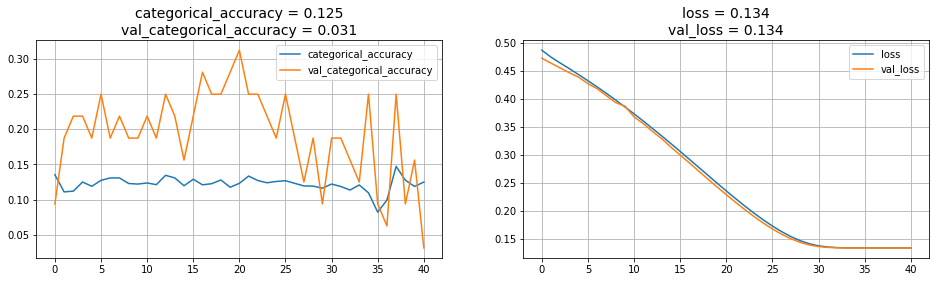

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.legend(['categorical_accuracy', 'val_categorical_accuracy'])
plt.title(('categorical_accuracy = {}\nval_categorical_accuracy = {}'.format(round(hist.history['categorical_accuracy'][-1],3), 
                                                   round(hist.history['val_categorical_accuracy'][-1],3))), fontsize=14)
plt.grid(True)
plt.subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title(('loss = {}\nval_loss = {}'.format(round(hist.history['loss'][-1],3), 
                                           round(hist.history['val_loss'][-1],3))), fontsize=14)
plt.grid(True)
plt.show();

In [18]:
model.load_weights('model_VGG16_fish.h5')

In [19]:
import pandas as pd

FISH_CLASSES = os.listdir('train')

if '.DS_Store' in FISH_CLASSES:
  FISH_CLASSES.remove('.DS_Store')

print('Prediction a part_1:')
test_pred_1 = model.predict(predict_generator(test_files_1), steps=len(test_files_1), verbose=1)
submission_1 = pd.DataFrame(test_pred_1, columns=FISH_CLASSES)
submission_1.insert(0, 'image', [i[10:] for i in test_files_1])

print('\nPrediction a part_2:')
test_pred_2 = model.predict(predict_generator(test_files_2), steps=len(test_files_2), verbose=1)
submission_2 = pd.DataFrame(test_pred_2, columns=FISH_CLASSES)
submission_2.insert(0, 'image', test_files_2)

submission = pd.concat([submission_1, submission_2])
submission.to_csv('submission.csv', index=False)

print('\nFinish prediction')

Prediction a part_1:
1000/1000 [==============================] - 30s 30ms/step

Prediction a part_2:
12153/12153 [==============================] - 311s 26ms/step

Finish prediction
